In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [01:18<00:00, 31.4MB/s]

Extracting files...


Path to dataset files: /Users/giuliasaresini/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [10]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import seaborn as sns

In [17]:
import os
import cv2
import numpy as np

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                # Carica e ridimensiona l'immagine
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Ridimensiona l'immagine
                
                # Aggiungi immagine e etichetta come una coppia
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Errore nel caricamento dell'immagine {img}: {e}")
    
    # Converti la lista in un array NumPy
    data = np.array(data, dtype=object)  # Usa dtype=object per consentire la combinazione immagine-etichetta
    return data

# Carica i dati
train_data = get_training_data('/Users/giuliasaresini/Documents/tesi_vs/Medicine/Progetto/chest_xray/train')
test_data = get_training_data('/Users/giuliasaresini/Documents/tesi_vs/Medicine/Progetto/chest_xray/test')
val_data = get_training_data('/Users/giuliasaresini/Documents/tesi_vs/Medicine/Progetto/chest_xray/val')


In [18]:
print(train_data.shape, val_data.shape )

(5216, 2) (16, 2)


# LET'S SEE IF THE CLASS ARE BALANCED OR NOT

In [19]:
import pandas as pd

# Supponiamo che 'train_data' contenga i dati con etichette già assegnate
l = []
for i in train_data:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

# Creare un DataFrame con pandas
df = pd.DataFrame(l, columns=['Class'])

# Calcolare la frequenza di ciascuna classe
class_counts = df['Class'].value_counts()

# Stampare la frequenza delle classi
print("Frequenza delle classi nel training set:")
print(class_counts)


Frequenza delle classi nel training set:
Class
Pneumonia    3875
Normal       1341
Name: count, dtype: int64


Abbiamo classi sbilanciate, quindi applichiamo tecniche di data augmentation

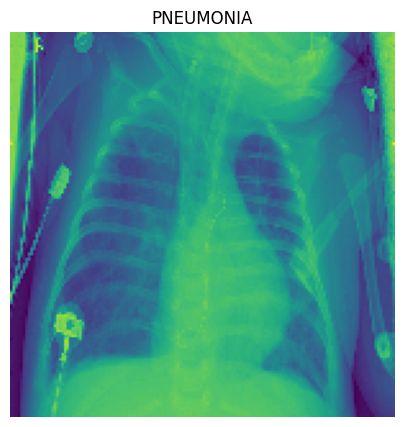

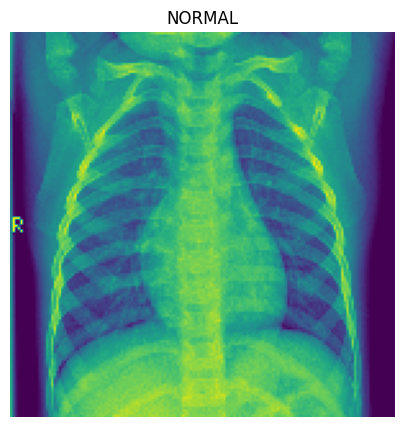

In [20]:
import matplotlib.pyplot as plt

# Visualizza la prima immagine
plt.figure(figsize=(5, 5))
plt.imshow(train_data[0][0])  # Assicurati che il formato sia RGB
plt.title(labels[train_data[0][1]])
plt.axis('off')  # Disabilita gli assi per una visualizzazione pulita
plt.show()

# Visualizza l'ultima immagine
plt.figure(figsize=(5, 5))
plt.imshow(train_data[-1][0])  # Assicurati che il formato sia RGB
plt.title(labels[train_data[-1][1]])
plt.axis('off')  # Disabilita gli assi per una visualizzazione pulita
plt.show()


In [47]:
import numpy as np
import cv2

# Funzione per normalizzare le immagini
def normalize_images(data):
    images = []
    labels = []
    
    for img, label in data:
        # Normalizzazione: ogni pixel viene diviso per 255
        normalized_img = img / 255.0
        images.append(normalized_img)
        labels.append(label)
    
    # Converti le immagini e le etichette in array separati
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

# Normalizza le immagini nel dataset di addestramento
train_images, train_labels = normalize_images(train_data)
val_images, val_labels = normalize_images(val_data)
test_images, test_labels = normalize_images(test_data)

# Verifica la forma e un esempio dei dati normalizzati
print(f"Shape of normalized train images: {train_images.shape}")

Shape of normalized train images: (5216, 150, 150)


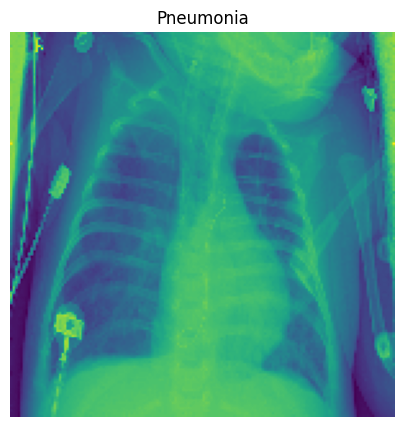

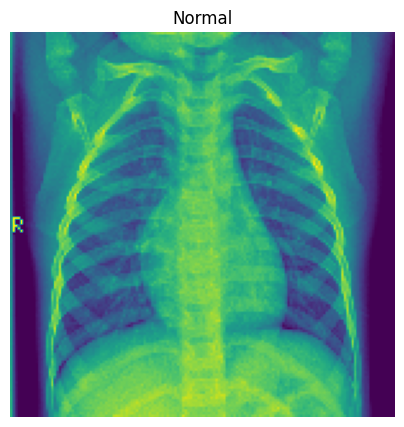

In [22]:
# Separiamo le immagini e le etichette
train_images = np.array([x[0] for x in train_data])  # Estrai solo le immagini
train_labels = np.array([x[1] for x in train_data])  # Estrai solo le etichette

# Visualizzare la prima immagine
plt.figure(figsize=(5, 5))
plt.imshow(train_images[0])  # La prima immagine
plt.title('Pneumonia' if train_labels[0] == 0 else 'Normal')  # Impostare il titolo in base all'etichetta
plt.axis('off')  # Per non mostrare gli assi
plt.show()

# Visualizzare l'ultima immagine
plt.figure(figsize=(5, 5))
plt.imshow(train_images[-1])  # L'ultima immagine
plt.title('Pneumonia' if train_labels[-1] == 0 else 'Normal')  # Impostare il titolo in base all'etichetta
plt.axis('off')  # Per non mostrare gli assi
plt.show()

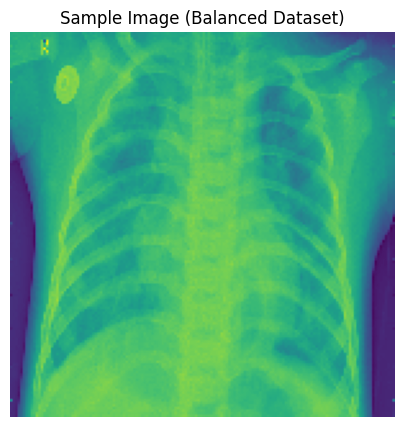

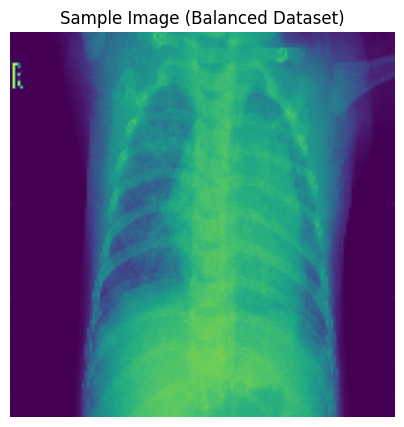

Numero di immagini Pneumonia: 3875
Numero di immagini Normal (originali + augmentate): 3875
Numero totale di immagini nel dataset bilanciato: 7750


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

# Identificare le immagini delle classi "Normal" e "Pneumonia"
normal_images = train_images[train_labels == 1]  # Solo le immagini "Normal"
normal_labels = train_labels[train_labels == 1]  # Etichette corrispondenti
pneumonia_images = train_images[train_labels == 0]  # Solo le immagini "Pneumonia"
pneumonia_labels = train_labels[train_labels == 0]  # Etichette corrispondenti

# Aggiungere una dimensione per il canale (1 per immagini in scala di grigio)
normal_images = np.expand_dims(normal_images, axis=-1)
pneumonia_images = np.expand_dims(pneumonia_images, axis=-1)

# Determinare il numero di immagini target per bilanciare il dataset
target_normal_images_count = pneumonia_images.shape[0]
current_normal_images_count = normal_images.shape[0]
images_to_generate = target_normal_images_count - current_normal_images_count

# Creare un ImageDataGenerator per l'augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generare le immagini aumentate per bilanciare il dataset
augmented_normal_images = []
if images_to_generate > 0:
    augmented_data_gen = datagen.flow(normal_images, normal_labels, batch_size=32, shuffle=False)
    for _ in range(images_to_generate // 32 + 1):
        batch_images, _ = next(augmented_data_gen)
        augmented_normal_images.append(batch_images)

    # Concatenare tutte le immagini generate
    augmented_normal_images = np.vstack(augmented_normal_images)[:images_to_generate]
else:
    augmented_normal_images = np.empty((0, *normal_images.shape[1:]))

# Concatenare le immagini originali e quelle aumentate per la classe "Normal"
balanced_normal_images = np.concatenate([normal_images, augmented_normal_images])
balanced_normal_labels = np.full(balanced_normal_images.shape[0], 1)

# Creare il dataset finale bilanciato
augmented_train_images = np.concatenate([pneumonia_images, balanced_normal_images])
augmented_train_labels = np.concatenate([pneumonia_labels, balanced_normal_labels])

# Mescolare il dataset in modo casuale
augmented_train_images, augmented_train_labels = shuffle(augmented_train_images, augmented_train_labels)

# Visualizzare alcune immagini per conferma
plt.figure(figsize=(5, 5))
plt.imshow(augmented_train_images[0].reshape(150, 150))
plt.title('Sample Image (Balanced Dataset)')
plt.axis('off')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(augmented_train_images[-1].reshape(150, 150))
plt.title('Sample Image (Balanced Dataset)')
plt.axis('off')
plt.show()

# Verifica del bilanciamento
print("Numero di immagini Pneumonia:", pneumonia_images.shape[0])
print("Numero di immagini Normal (originali + augmentate):", balanced_normal_images.shape[0])
print("Numero totale di immagini nel dataset bilanciato:", augmented_train_images.shape[0])

In [28]:
augmented_train_images.shape

(7750, 150, 150, 1)

# ORA DEVO NORMALIZZARE LE IMMAGINI AUMENTATE

In [29]:
augmented_train_images_normalized = augmented_train_images / 255.0

In [ ]:
import numpy as np

# Aggiungere un canale per immagini in scala di grigi
val_images = np.expand_dims(val_images, axis=-1)  # Diventa (16, 150, 150, 1)
val_images.shape